In [1]:
import numpy as np
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'false'


# Loading data

In [2]:
# load dataset
import pandas as pd
noteChat_df = pd.read_csv("./Dataset/our_revised_v2.csv", usecols=["data"])
noteChat_df.head()

,data
0,This 60-year-old male was hospitalized due to ...
1,A 39-year-old man was hospitalized due to an i...
2,One week after a positive COVID-19 result this...
3,This 69-year-old male was admitted to the ICU ...
4,This 57-year-old male was admitted to the ICU ...


# Exploring Demographic Features 

- Exploring Demographic Features in Patient Descriptions Using Llama3 Model and Zero-shot prompting 

In [3]:
# Create model and prompt template
local_llm = 'llama3'
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)
prompt = PromptTemplate(
    template="""
        You are a world-class algorithm for extracting information in structured formats. 
        Extract demographic features names without values from the patient description in a JSON format. 
        
        The patient description:
        {description}
        """,
    input_variables=["description"],
)

feature_explorer_model = prompt | llm | JsonOutputParser()




In [4]:
from tqdm.notebook import tqdm
from collections import defaultdict

# Because running the model is time-consuming I am going to run it for 100 data points.

demographic_features = defaultdict(lambda : 0)
for i, row in tqdm(noteChat_df.iloc[:100].iterrows()):
    output = feature_explorer_model.invoke({"description": row['data']})
    output = list(output.values())[0]
    # try:
    for item in output:
        # print(item)
        if isinstance(item, dict):
            item = list(item.values())
            feature = item[0].lower()
        elif isinstance(item, str):
            # print("str", item)
            feature = item.lower()
        else:
            print(type(item), output)
            raise RuntimeError()
        demographic_features[feature] += 1
    # except:
    #     print(output)

0it [00:00, ?it/s]

# Investigating Demographic Features Found in the Dataset

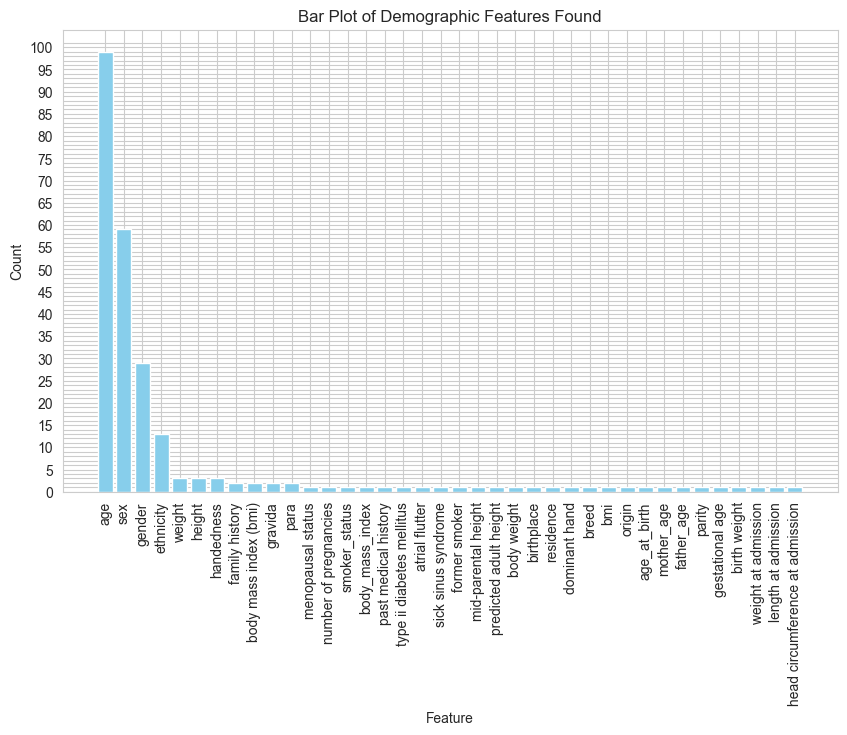

In [5]:
import matplotlib.pyplot as plt

sorted_demographic_features = dict(sorted(demographic_features.items(), key=lambda item: item[1],reverse=True))
sorted_demographic_features
keys = list(sorted_demographic_features.keys())
values = list(sorted_demographic_features.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Bar Plot of Demographic Features Found')
plt.xticks(rotation=90)
y_ticks = range(0, max(values) + 3)
y_labels = [str(tick) if tick % 5 == 0 else '' for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels)

plt.show()

In [6]:
# Select top k features based on their count
k = 4
final_demographic_features = sorted(demographic_features, key=demographic_features.get, reverse=True)[:k]
final_demographic_features.pop(2)
final_demographic_features

['age', 'sex', 'ethnicity']

# Extracting features from each patient description
Features are:
- Disease Name (Srting)
- Age (number)
- Ethnicity (Srting)
- Sex (male or female)
- Disease Severity (Srting)
- Disease treated (yes or no)
- Survival Status (alive or died)

In [7]:
# prompt_text = """
# You are a world-class algorithm for extracting information in structured formats. 
# Extract the attribute values from the patient descriptions in a JSON format. 
# Valid attributes are Disease, """ + ", ".join(final_demographic_features[:-1]) + """, Survival Status if died or survived or unknown. 
# If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

# prompt_text = """
# Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are Disease Type, Age, Ethnicity, Sex, Disease Severity, Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

# prompt_text = """
# Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are each patient’s disease status (treated, mild, moderate, severe) and which disease, Age, Ethnicity, Sex, , Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

# prompt_text = """
# Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are Disease Type, Age, Ethnicity, Sex, Disease Severity, disease treated or not, Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

prompt_text = """
Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are 

- Disease Name
- Age (number)
- Ethnicity (Srting)
- Sex (male or female)
- Disease Severity (Srting)
- Disease treated (yes or no)
- Survival Status (alive or died)

If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.

The patient description:
{description}
"""


prompt = PromptTemplate(
    template=prompt_text,
    input_variables=["description"],
)

feature_extractor_model = prompt | llm | JsonOutputParser()



In [9]:
description =""""A 40-year-old male engineer, former professional rugby player, was referred to our clinic with a left heel inflammatory pain that was worsening during jogging or trailing. The symptoms started seven months before and the patient presented to a regional local hospital for investigations where a plain radiography was performed and a simple bone cyst diagnosis was suspected. Patient was recommended a break from physical activity for six months and non-steroid anti-inflammatories drugs (NSAIDS) to ameliorate pain. The pain increased gradually and he started to complain of swelling. The pain was hardly controlled with NSAIDS and non-morphinic analgesics.
Our clinical examination revealed a mild tenderness in the posterior foot, including the ankle and the heel, without evidence of a palpable mass. Ankle and subtalar joint mobilities were limited. The laboratory blood tests and urine analysis results were normal.
Radiography revealed a benign-appearing bone lesion of 16 Ã— 19 mm within the anteroinferior part of the calcaneum which was well defined, radiolucent, almost entirely homogeneous with a small central sclerotic focus-â€œCockade signâ€ [,], describing the classical appearance of a calcaneal intraosseous lipoma (). We also performed and MRI exam that showed a focal lesion, hyperintense on both T1 and T2 weighted images, and isointense with fatty tissues (a,b). There was a discreet focal attenuation in the center of the lesion, on T2* sequence, suggestive for focal calcification (c). The MRI aspect corresponded to a Milgram type II intraosseous lipoma (predominantly fatty lesions with central necrosis/calcifications/ ossifications) [].
Surgery was performed and a direct lateral approach to the calcaneum was chosen. The saphenous nerve and the long peroneus tendon were reclined superiorly and distally (a). A bone window was performed immediate distally to the lateral tubercle"
"""
print(feature_extractor_model.invoke({"description": description}))


{'Disease Name': 'Calcaneal intraosseous lipoma', 'Age': 40, 'Ethnicity': 'n/a', 'Sex': 'male', 'Disease Severity': 'mild', 'Disease treated': 'yes', 'Survival Status': 'alive'}


In [10]:
outputs = []
for i, row in tqdm(noteChat_df.iloc[:100].iterrows()):
    output = feature_extractor_model.invoke({"description": row['data']})
    outputs.append(output)

0it [00:00, ?it/s]

In [44]:
import pickle

# saving results, because running them again takes time.
with open('./outputfiles/feature_extractor_outputs.pickle', 'wb') as f:
    pickle.dump(outputs, f, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
import pickle
# loading results
with open('./outputfiles/feature_extractor_outputs.pickle', 'rb') as f:
    outputs = pickle.load(f)

In [11]:
# Verify the Absence of Additional Features Created by the Model

feature_names = [
    k for o in outputs for k in o.keys()
]
feature_names = list(set(feature_names))
feature_names

['Disease Severity',
 'Age',
 'Sex',
 'Disease Name',
 'Disease treated',
 'Survival Status',
 'Ethnicity']

# Creating DataFrame for extracted features

In [12]:
outputs_dict = {k:[] for k in feature_names}

for i, o in enumerate(outputs):
    for f in feature_names:
        if f in o.keys():
            outputs_dict[f].append(o[f])
        else:
            outputs_dict[f].append('n/a')
            
# for f in feature_names:
#     print(len(outputs_dict[f]))

In [13]:
outputs_df = pd.DataFrame(outputs_dict)
outputs_df.head(5)

,Disease Severity,Age,Sex,Disease Name,Disease treated,Survival Status,Ethnicity
0,moderate,60,male,ARDS from COVID-19,yes,alive,n/a
1,severe,39,male,n/a,yes,alive,n/a
2,severe,57,male,COVID-19,yes,alive,n/a
3,severe,69,male,COVID-19 pneumonia,yes,died,n/a
4,n/a,57,male,COVID-19,yes,alive,n/a


In [14]:
outputs_df.describe()

,Disease Severity,Age,Sex,Disease Name,Disease treated,Survival Status,Ethnicity
count,100,100,100,100,100,100,100
unique,25,63,2,71,3,2,11
top,n/a,57,male,n/a,yes,alive,n/a
freq,54,4,55,11,81,96,82


In [15]:
import re

# Removing 'year' from Age Values Using Regex. ex: 5 years 0 -> 5

def clean_digits(x):
    return re.sub('[^\d\.]', '', str(x))
outputs_df.loc[:, "Age"]  = outputs_df.loc[:, "Age"].apply(clean_digits).astype(float)


In [16]:
outputs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Disease Severity  100 non-null    object
 1   Age               100 non-null    object
 2   Sex               100 non-null    object
 3   Disease Name      100 non-null    object
 4   Disease treated   100 non-null    object
 5   Survival Status   100 non-null    object
 6   Ethnicity         100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


# Disease Categorization
- Since there are many diseases found in this dataset, I am going to assign them to the more general categories to which these diseases belong. A disease might be assigned to more than one category. For example, "Lung Adenocarcinoma" is assigned to ["Cancer", "Lung Cancer"].
- To determine these general categories, I received assistance from ChatGPT. But assignmet to these categories is done using llama3 model and one shot prompting.



In [17]:
prompt_text = """
You are a skilled medical professional with extensive knowledge of disease nomenclature and classification. Your task is to relate the given disease to one or more of the following categories and return the output in JSON format:

- COVID-19 and Related Conditions
- Mood and Anxiety Disorders
- Lung Cancer
- Inflammatory Bowel Disease
- Autoimmune Disorders
- Infectious Diseases
- Neurological Disorders
- Gastrointestinal Diseases
- Cardiovascular Disorders
- Inflammatory Diseases
- Cancer
- Infectious Complications
- Genetic Disorders
- Fetal Anomalies
- Gynecological Diseases
- Surgical Complications
- Miscellaneous

For example:
```json

  "Lung Adenocarcinoma": ["Cancer", "Lung Cancer"]

```


Here is the Disease name:
{name}
"""


prompt = PromptTemplate(
    template=prompt_text,
    input_variables=["name"],
)

disease_clustering_model = prompt | llm | JsonOutputParser()

In [18]:
disease_categories = [
    'COVID-19 and Related Conditions',
    'Mood and Anxiety Disorders',
    'Lung Cancer',
    'Inflammatory Bowel Disease',
    'Autoimmune Disorders',
    'Infectious Diseases',
    'Neurological Disorders',
    'Gastrointestinal Diseases',
    'Cardiovascular Disorders',
    'Inflammatory Diseases',
    'Cancer',
    'Infectious Complications',
    'Genetic Disorders',
    'Fetal Anomalies',
    'Gynecological Diseases',
    'Surgical Complications',
    'Miscellaneous',]

In [19]:
categorised_diseases = {}

for d in outputs_df['Disease Name'].unique():
    if d == 'n/a':
        continue
    temp_var = disease_clustering_model.invoke({"name": d})
    categories = list(temp_var.values())[0]
    categorised_diseases[d] = categories
categorised_diseases    

{'ARDS from COVID-19': ['Infectious Diseases',
  'COVID-19 and Related Conditions'],
 'COVID-19': ['Infectious Diseases', 'COVID-19 and Related Conditions'],
 'COVID-19 pneumonia': ['Infectious Diseases',
  'Pneumonia',
  'COVID-19 and Related Conditions'],
 'ARDS': ['Infectious Diseases', 'Pulmonary Disorders'],
 'SARS-CoV-2': ['COVID-19 and Related Conditions', 'Infectious Diseases'],
 'Restrictive AN': ['Pulmonary Disease', 'Inflammatory Diseases'],
 'Invasive Mammary Carcinoma': ['Cancer', 'Breast Cancer'],
 'liver cirrhosis': ['Inflammatory Diseases', 'Gastrointestinal Diseases'],
 'LCH': ['Autoimmune Disorders', 'Inflammatory Bowel Disease'],
 'Endometrial cancer': ['Gynecological Diseases', 'Cancer'],
 'Cutaneous T-cell lymphoma/mycosis fungoides': ['Autoimmune Disorders',
  'Cancer'],
 'Multiple Sclerosis': ['Autoimmune Disorders'],
 'UC': ['Inflammatory Bowel Disease', 'Autoimmune Disorders'],
 'PAMM': ['Infectious Diseases', 'Autoimmune Disorders'],
 'adenocarcinoma': ['Cance

In [20]:
for c in disease_categories:
    outputs_df[c] = np.zeros(outputs_df.shape[0])



for i, row in outputs_df.iterrows():
    disease = row['Disease Name']
    if disease == 'n/a':
        continue
        
    categories = categorised_diseases[disease]
    for c in categories:
        if c in outputs_df.columns:
            outputs_df.loc[i, c] = 1
        else:
            # Beside from those mentioned categories, model came up with new ones, but we are ignoring them.
            print(i, disease, ', ', c, categories)
            

3 COVID-19 pneumonia ,  Pneumonia ['Infectious Diseases', 'Pneumonia', 'COVID-19 and Related Conditions']
6 ARDS ,  Pulmonary Disorders ['Infectious Diseases', 'Pulmonary Disorders']
9 ARDS ,  Pulmonary Disorders ['Infectious Diseases', 'Pulmonary Disorders']
11 Restrictive AN ,  Pulmonary Disease ['Pulmonary Disease', 'Inflammatory Diseases']
13 Invasive Mammary Carcinoma ,  Breast Cancer ['Cancer', 'Breast Cancer']
45 Cutaneous candidiasis with intertrigo ,  Skin Disorders ['Infectious Diseases', 'Skin Disorders']
63 Tuberculous meningitis ,  Meningitis ['Infectious Diseases', 'Meningitis']


In [21]:
# Double check if there is any unassigned disease

outputs_df['Disease Name'][outputs_df[disease_categories].sum(axis=1) == 0].unique()

array(['n/a'], dtype=object)

In [24]:
# outputs_df.plot.hist(column=["COVID-19 and Related Conditions"], by="Sex", figsize=(10, 8))

# Converting all 'Caucasian (American)' and 'white' to 'Caucasian'

['n/a' 'Caucasian (American)' 'Caucasian' 'African American' 'Hispanic'
 'Sudanese' 'Japanese' 'Brown breed' 'Ukrainian' 'white' 'Korean']


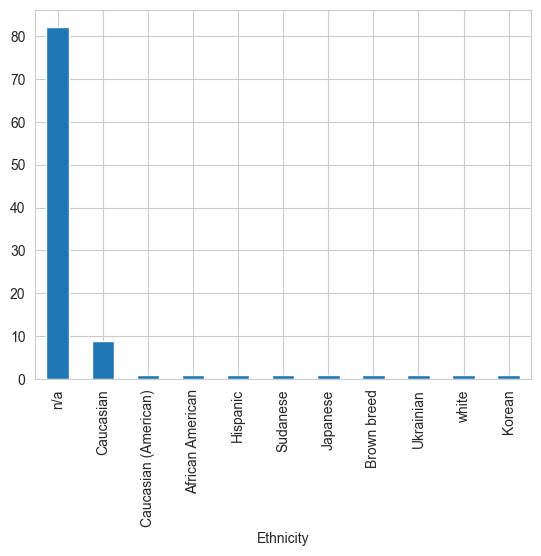

In [22]:
print(outputs_df['Ethnicity'].unique())
outputs_df['Ethnicity'].value_counts().plot.bar()
plt.show()

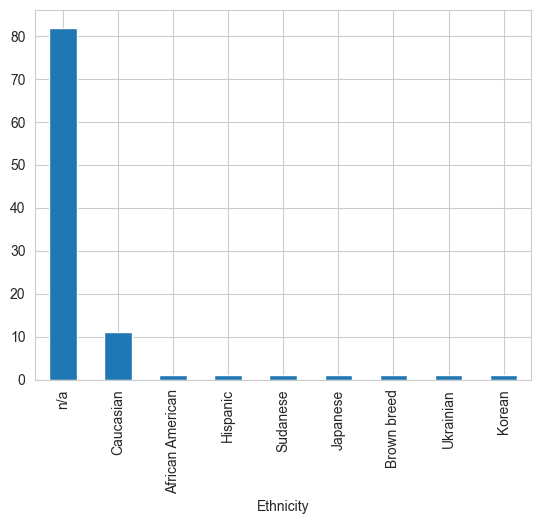

In [23]:
for i, row in outputs_df.iterrows():
    if 'Caucasian' in row['Ethnicity']:
        outputs_df.loc[i, 'Ethnicity'] = 'Caucasian'
    if 'white' in row['Ethnicity']:
        outputs_df.loc[i, 'Ethnicity'] = 'Caucasian'

outputs_df['Ethnicity'].value_counts().plot.bar()
plt.show()

# Disease Severity Categorization

I will categorize each disease severity identified by the model into one of the following groups: Mild, Moderate, Severe, or Very Severe. In cases where the severity is not clearly defined and a range is provided, such as "Mild to Severe," I will assign the severity to both the Mild and Severe categories.

In [25]:
print(outputs_df['Disease Severity'].unique())

['moderate' 'severe' 'n/a' 'moderate ARDS' 'Moderate' 'unstable'
 'highly suggestive of malignancy' 'advanced' 'stable'
 'high-grade tumor cells'
 'mildly patchy bibasilar pulmonary infiltrates and a calcified pulmonary nodule'
 'mild to severe' 'mild to moderate' 'stage IVb'
 'subfebrile temperatures for 1 week and localized pain in his right popliteal fossa for 3 days'
 'mild' 'Fisher I, Hunt, and Hess II' 'mild progressive' 'adverse risk'
 'de novo metastatic' 'persistent' 'progressive asymmetric hearing loss'
 'profound' 'complicated' 'severe anemia']


In [26]:
prompt_text = """
You are a skilled medical professional with extensive knowledge of disease severity classification. Your task is to relate the given phrase to one or more of the following categories and return the list of categories in JSON format:


- Mild
- Moderate
- Severe
- Very Severe

Here is the phrase:
{phrase}
"""


prompt = PromptTemplate(
    template=prompt_text,
    input_variables=["phrase"],
)

severity_clustering_model = prompt | llm | JsonOutputParser()

In [27]:
severity_categories = [
    "Mild",
    "Moderate",
    "Severe",
    "Very Severe",
]

In [29]:
categorised_severities = {}

for s in outputs_df['Disease Severity'].unique():
    if s == 'n/a':
        continue
    temp_var = severity_clustering_model.invoke({"phrase": s})
    categories = list(temp_var.values())[0]
    categorised_severities[s] = categories
categorised_severities    

{'moderate': ['Moderate'],
 'severe': ['Severe'],
 'moderate ARDS': ['Moderate', 'Severe'],
 'Moderate': ['Moderate'],
 'unstable': ['Severe', 'Very Severe'],
 'highly suggestive of malignancy': ['Severe', 'Very Severe'],
 'advanced': ['Severe', 'Very Severe'],
 'stable': ['Mild'],
 'high-grade tumor cells': ['Severe', 'Very Severe'],
 'mildly patchy bibasilar pulmonary infiltrates and a calcified pulmonary nodule': ['Mild',
  'Moderate'],
 'mild to severe': ['Mild', 'Severe'],
 'mild to moderate': ['Mild', 'Moderate'],
 'stage IVb': ['Severe', 'Very Severe'],
 'subfebrile temperatures for 1 week and localized pain in his right popliteal fossa for 3 days': ['Mild',
  'Moderate'],
 'mild': ['Mild'],
 'Fisher I, Hunt, and Hess II': ['Mild', 'Moderate'],
 'mild progressive': ['Mild', 'Severe'],
 'adverse risk': ['Severe', 'Very Severe'],
 'de novo metastatic': ['Severe', 'Very Severe'],
 'persistent': ['Mild'],
 'progressive asymmetric hearing loss': ['Mild', 'Moderate'],
 'profound': ['S

In [30]:
for c in severity_categories:
    outputs_df[c] = np.zeros(outputs_df.shape[0])



for i, row in outputs_df.iterrows():
    severity = row['Disease Severity']
    if severity == 'n/a':
        continue
        
    categories = categorised_severities[severity]
    for c in categories:
        if c in outputs_df.columns:
            outputs_df.loc[i, c] = 1
        else:
            # Beside from those mentioned categories, model came up with new ones, but we are ignoring them.
            print(i, severity, ', ', c, categories)
            

In [31]:
outputs_df.head()

,Disease Severity,Age,Sex,Disease Name,Disease treated,Survival Status,Ethnicity,COVID-19 and Related Conditions,Mood and Anxiety Disorders,Lung Cancer,...,Infectious Complications,Genetic Disorders,Fetal Anomalies,Gynecological Diseases,Surgical Complications,Miscellaneous,Mild,Moderate,Severe,Very Severe
0,moderate,60.0,male,ARDS from COVID-19,yes,alive,n/a,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,severe,39.0,male,n/a,yes,alive,n/a,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,severe,57.0,male,COVID-19,yes,alive,n/a,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,severe,69.0,male,COVID-19 pneumonia,yes,died,n/a,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,n/a,57.0,male,COVID-19,yes,alive,n/a,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Query These:
# For each disease column, plot all severities bar plot
# For each disease column, plot age population
# For each disease column plot Survival bar plot and calculate the rate of survival (ignore n/a values)
# For each disease column plot treatment  bar plot  and rate of treatment (ignore n/a values)
# For each disease column plot ethnicity  bar plot 
# For each disease column plot gender  bar plot
# For each disease column calculate rate of survival for each gender.
# Fore each disease column calculate rate of treatment for each gender.
# For each disease column calculate rate of survival for each age.
# For each disease column calculate rate of treatment for each age






In [32]:
import seaborn as sns

In [33]:
# Function to plot severity bar plot
def plot_severity(df, disease):
    severities = ['Mild', 'Moderate', 'Severe', 'Very Severe']
    severity_counts = df[df[disease] == 1][severities].sum()
    severity_counts.plot(kind='bar', title=f'{disease} Severities')
    plt.ylabel('Count')
    plt.show()

# Function to plot age population
def plot_age_population(df, disease):
    data = df[df[disease] == 1]['Age']
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data, bins=10, kde=False)
    ax.set_title(f'{disease} Age Population')
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
    
    # Adding x-axis values on top of bars if y-axis value > 0
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            # x-position is the center of the bar
            x = p.get_x() + p.get_width() / 2
            # get the bin range
            bin_range = f'{int(p.get_x())}-{int(p.get_x() + p.get_width())}'
            ax.annotate(f'{bin_range}', (x, height), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    plt.show()


# Function to plot survival bar plot and calculate survival rate
def plot_survival(df, disease):
    survival_counts = df[df[disease] == 1]['Survival Status'].value_counts()
    survival_counts.plot(kind='bar', title=f'{disease} Survival Status')
    plt.ylabel('Count')
    plt.show()
    
    survival_rate = survival_counts['alive'] / survival_counts.sum() if 'alive' in survival_counts else 0
    print(f'Survival rate for {disease}: {survival_rate:.2f}')

# Function to plot treatment bar plot and calculate treatment rate
def plot_treatment(df, disease):
    treatment_counts = df[df[disease] == 1]['Disease treated'].value_counts()
    treatment_counts.plot(kind='bar', title=f'{disease} Treatment Status')
    plt.ylabel('Count')
    plt.show()
    
    treatment_rate = treatment_counts['yes'] / treatment_counts.sum() if 'yes' in treatment_counts else 0
    print(f'Treatment rate for {disease}: {treatment_rate:.2f}')

# Function to plot ethnicity bar plot
def plot_ethnicity(df, disease):
    ethnicity_counts = df[df[disease] == 1]['Ethnicity'].value_counts()
    ethnicity_counts.plot(kind='bar', title=f'{disease} Ethnicity Distribution')
    plt.ylabel('Count')
    plt.show()

# Function to plot gender bar plot
def plot_gender(df, disease):
    gender_counts = df[df[disease] == 1]['Sex'].value_counts()
    gender_counts.plot(kind='bar', title=f'{disease} Gender Distribution')
    plt.ylabel('Count')
    plt.show()

# Function to calculate rate of survival for each gender
def survival_rate_by_gender(df, disease):
    survival_gender = df[df[disease] == 1].groupby('Sex')['Survival Status'].value_counts(normalize=True).unstack()
    print(f'Survival rate by gender for {disease}:\n', survival_gender)

# Function to calculate rate of treatment for each gender
def treatment_rate_by_gender(df, disease):
    treatment_gender = df[df[disease] == 1].groupby('Sex')['Disease treated'].value_counts(normalize=True).unstack()
    print(f'Treatment rate by gender for {disease}:\n', treatment_gender)

# Function to calculate rate of survival for each age
def survival_rate_by_age(df, disease):
    survival_age = df[df[disease] == 1].groupby('Age')['Survival Status'].value_counts(normalize=True).unstack()
    print(f'Survival rate by age for {disease}:\n', survival_age)

# Function to calculate rate of treatment for each age
def treatment_rate_by_age(df, disease):
    treatment_age = df[df[disease] == 1].groupby('Age')['Disease treated'].value_counts(normalize=True).unstack()
    print(f'Treatment rate by age for {disease}:\n', treatment_age)




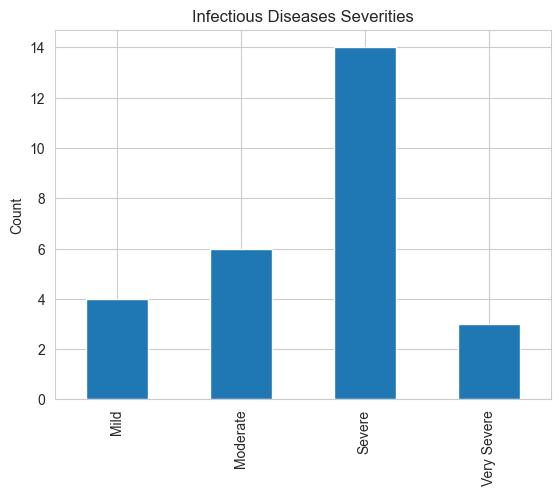

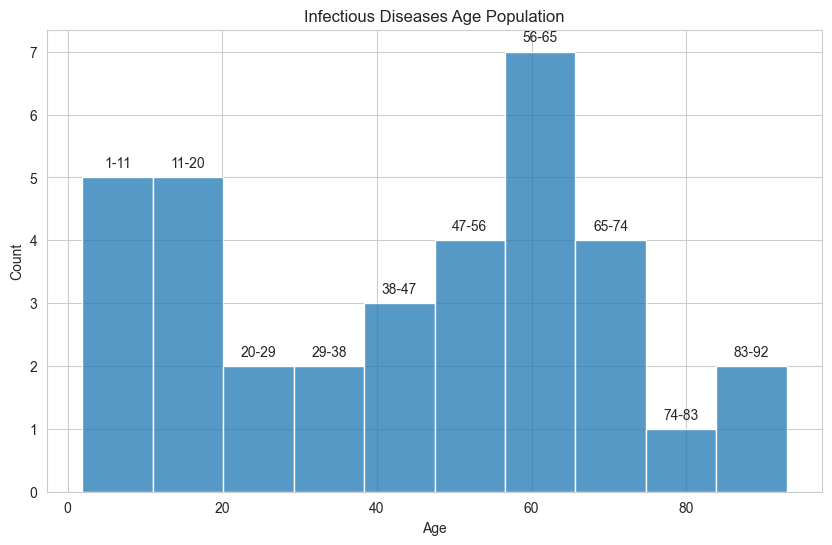

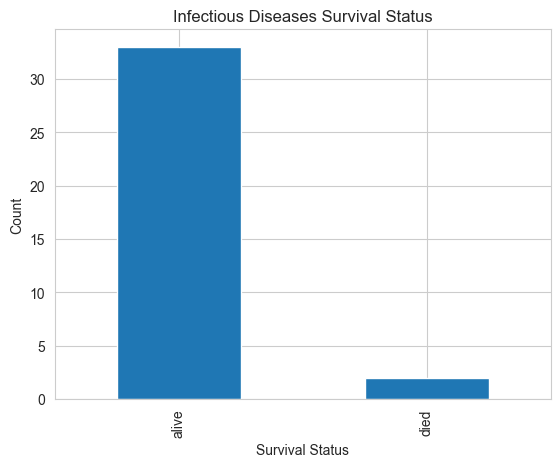

Survival rate for Infectious Diseases: 0.94


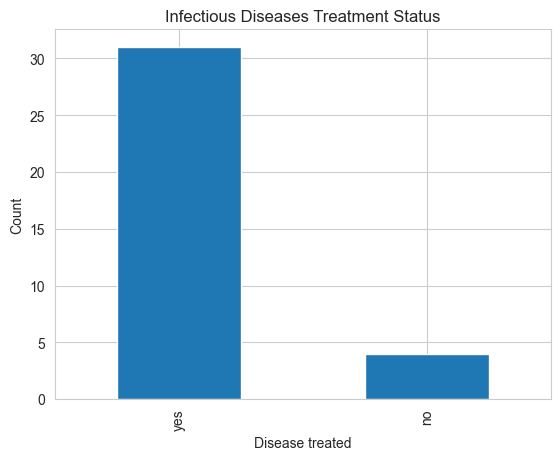

Treatment rate for Infectious Diseases: 0.89


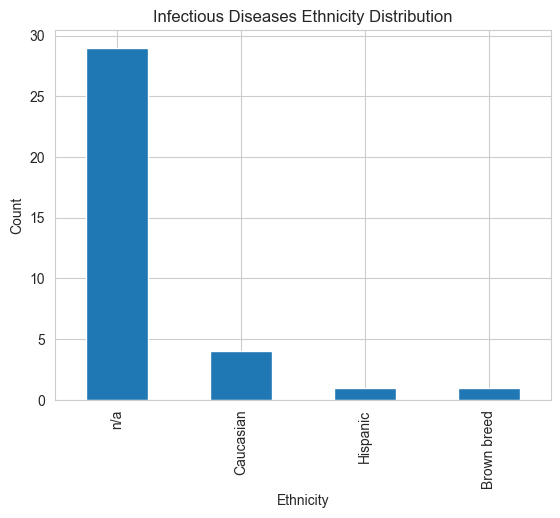

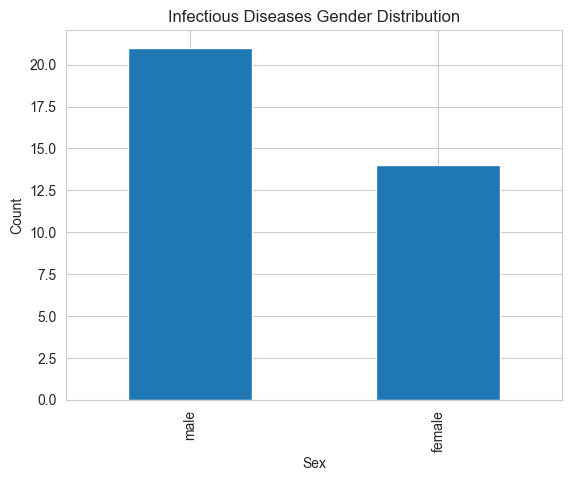

Survival rate by gender for Infectious Diseases:
 Survival Status     alive      died
Sex                                
female           0.928571  0.071429
male             0.952381  0.047619
Treatment rate by gender for Infectious Diseases:
 Disease treated        no       yes
Sex                                
female           0.071429  0.928571
male             0.142857  0.857143
Survival rate by age for Infectious Diseases:
 Survival Status  alive  died
Age                         
1.9                1.0   NaN
4.0                1.0   NaN
5.0                1.0   NaN
6.0                1.0   NaN
11.0               1.0   NaN
12.0               1.0   NaN
14.0               1.0   NaN
15.0               1.0   NaN
20.0               1.0   NaN
22.0               1.0   NaN
23.0               1.0   NaN
33.0               1.0   NaN
37.0               1.0   NaN
44.0               1.0   NaN
47.0               1.0   NaN
48.0               1.0   NaN
52.0               1.0   NaN
54.0         

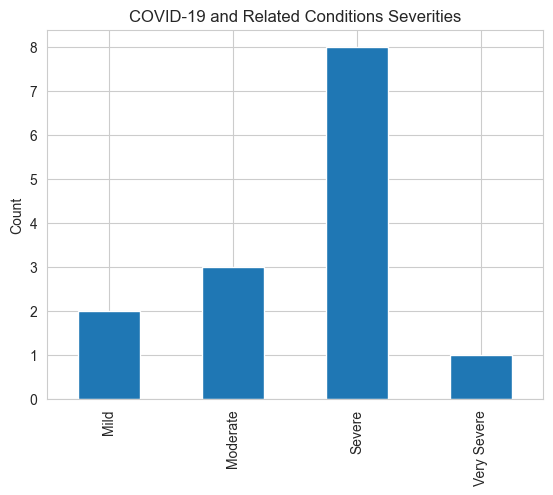

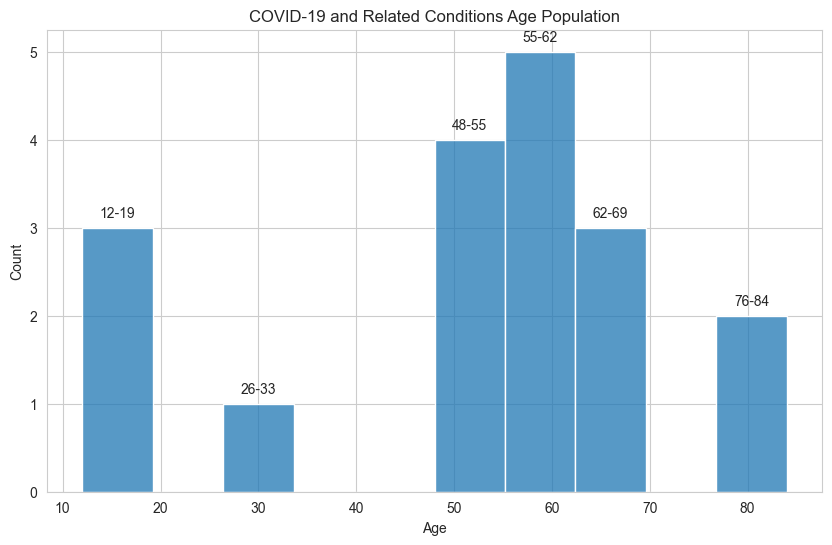

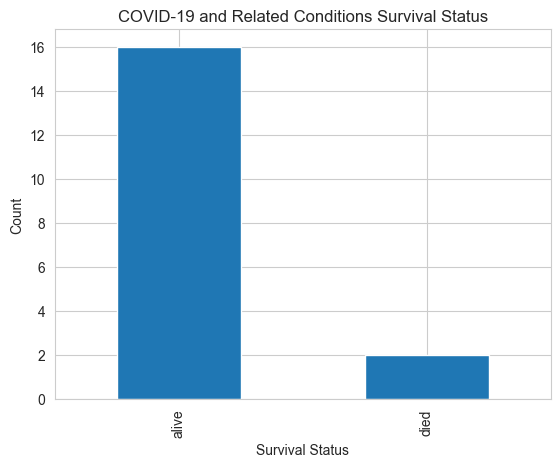

Survival rate for COVID-19 and Related Conditions: 0.89


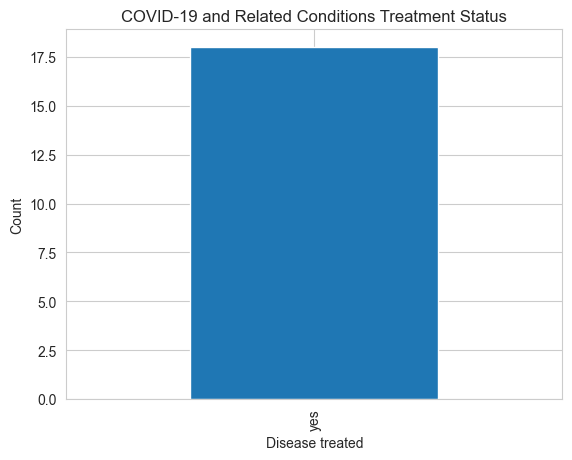

Treatment rate for COVID-19 and Related Conditions: 1.00


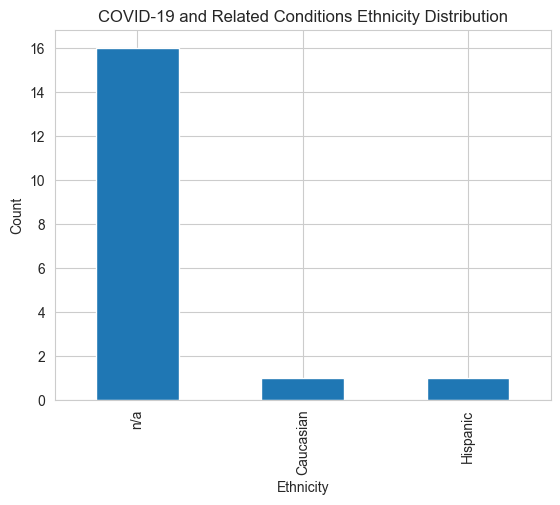

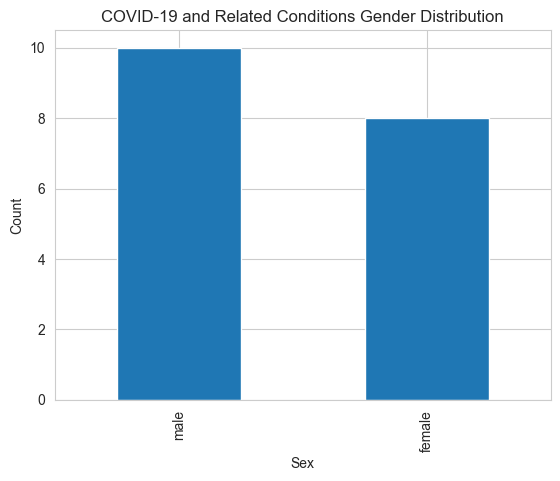

Survival rate by gender for COVID-19 and Related Conditions:
 Survival Status  alive   died
Sex                          
female           0.875  0.125
male             0.900  0.100
Treatment rate by gender for COVID-19 and Related Conditions:
 Disease treated  yes
Sex                 
female           1.0
male             1.0
Survival rate by age for COVID-19 and Related Conditions:
 Survival Status  alive  died
Age                         
12.0               1.0   NaN
14.0               1.0   NaN
15.0               1.0   NaN
33.0               1.0   NaN
48.0               1.0   NaN
52.0               1.0   NaN
54.0               1.0   NaN
57.0               1.0   NaN
58.0               1.0   NaN
60.0               1.0   NaN
61.0               1.0   NaN
66.0               1.0   NaN
67.0               1.0   NaN
69.0               NaN   1.0
77.0               1.0   NaN
84.0               NaN   1.0
Treatment rate by age for COVID-19 and Related Conditions:
 Disease treated  yes
Age      

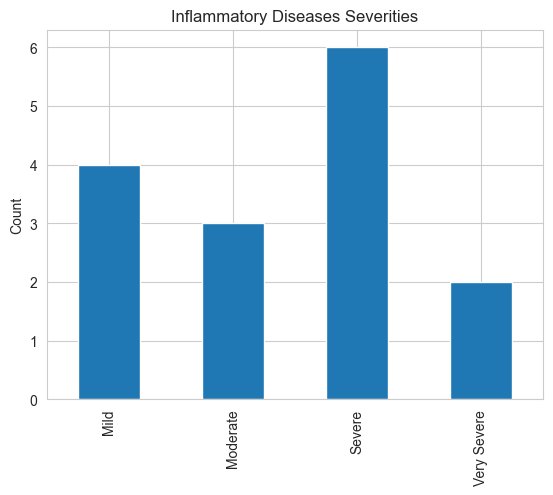

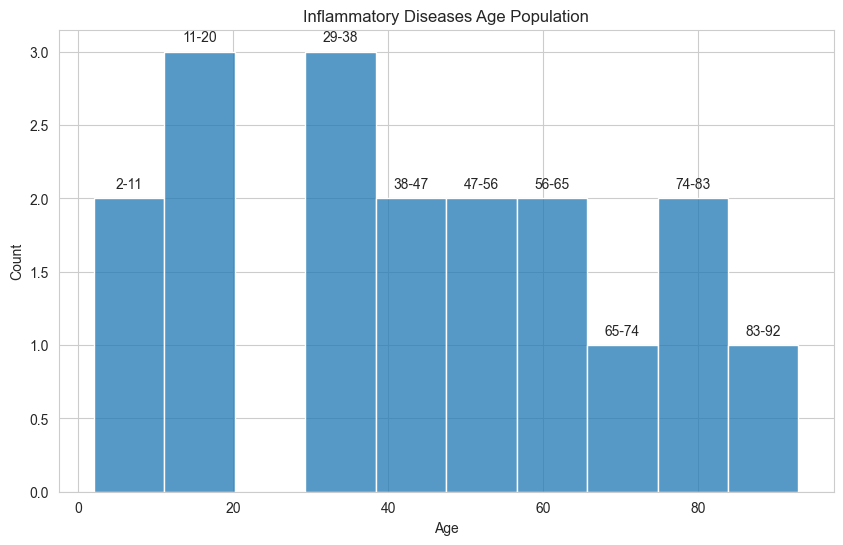

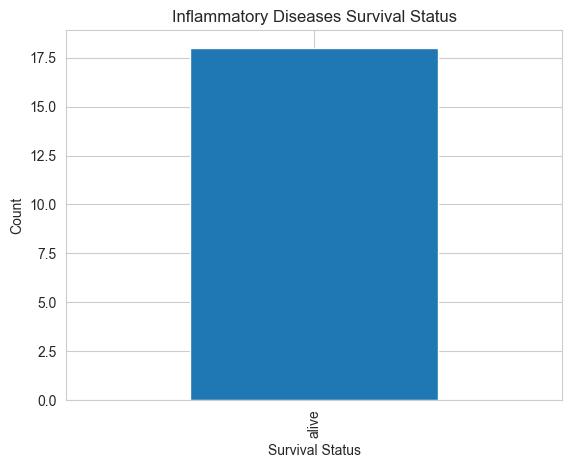

Survival rate for Inflammatory Diseases: 1.00


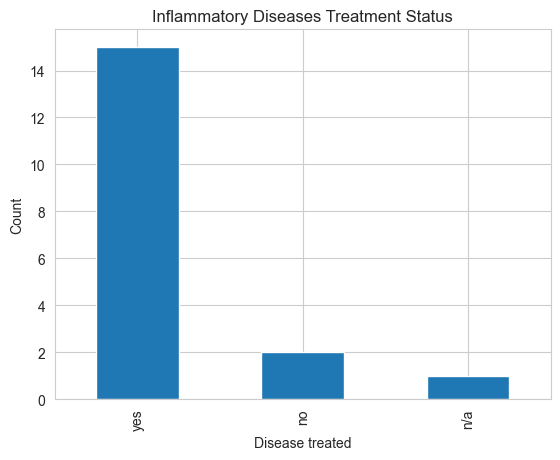

Treatment rate for Inflammatory Diseases: 0.83


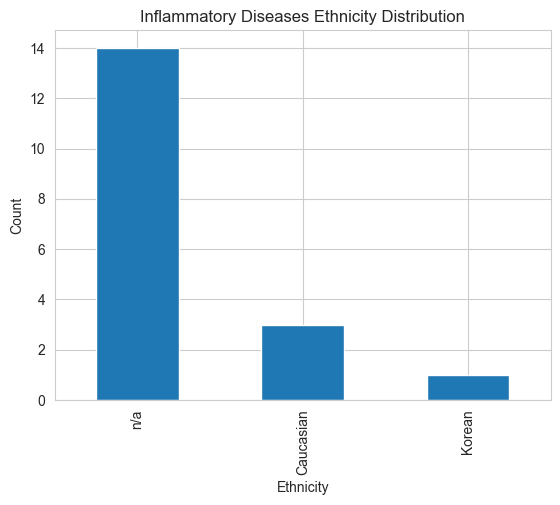

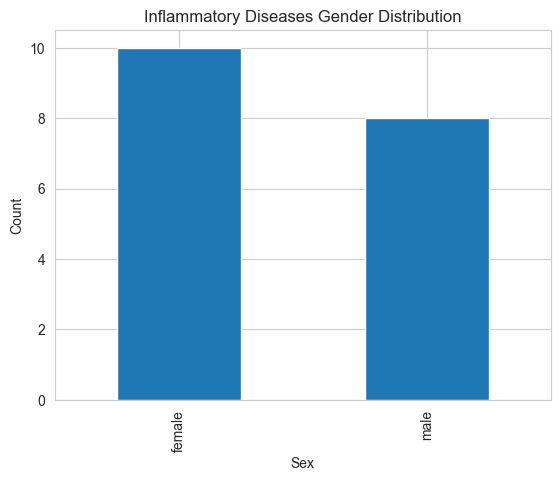

Survival rate by gender for Inflammatory Diseases:
 Survival Status  alive
Sex                   
female             1.0
male               1.0
Treatment rate by gender for Inflammatory Diseases:
 Disease treated  n/a     no    yes
Sex                               
female           0.1  0.100  0.800
male             NaN  0.125  0.875
Survival rate by age for Inflammatory Diseases:
 Survival Status  alive
Age                   
2.0                1.0
5.0                1.0
16.0               1.0
18.0               1.0
20.0               1.0
33.0               1.0
35.0               1.0
37.0               1.0
43.0               1.0
45.0               1.0
49.0               1.0
54.0               1.0
61.0               1.0
62.0               1.0
72.0               1.0
75.0               1.0
77.0               1.0
93.0               1.0
Treatment rate by age for Inflammatory Diseases:
 Disease treated  n/a   no  yes
Age                           
2.0              NaN  NaN  1.0
5.0        

In [34]:
# Run above functions for top 3 disease in terms of their count.

# Function to find top k diseases based on their counts
def find_top_k_diseases(df, disease_columns, k):
    # Calculate the sum for each disease column
    disease_counts = df[disease_columns].sum().sort_values(ascending=False)
    
    # Get the top k diseases
    top_k_diseases = disease_counts.head(k)
    
    return list(top_k_diseases.index)
k = 3
top_k_diseases = find_top_k_diseases(outputs_df, disease_categories, k)

functions = [
    plot_severity,
    plot_age_population,
    plot_survival,
    plot_treatment,
    plot_ethnicity,
    plot_gender,
    survival_rate_by_gender,
    treatment_rate_by_gender,
    survival_rate_by_age,
    treatment_rate_by_age,
]

for disease in top_k_diseases:
    for f in functions:
        f(outputs_df,  disease)


In [35]:
outputs_df.to_csv("outputfiles/df1.csv", index=False)